C:\Users\rodri\AppData\Local\Temp\ipykernel_24740\3772532449.py:29: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  df = pd.read_json(response.text)


Data retrieved and loaded into DataFrame.


OSError: [WinError 123] The filename, directory name, or volume label syntax is incorrect: 'C:\\Users\\rodri\\AppData\\Local\\Temp\\--f=c:'

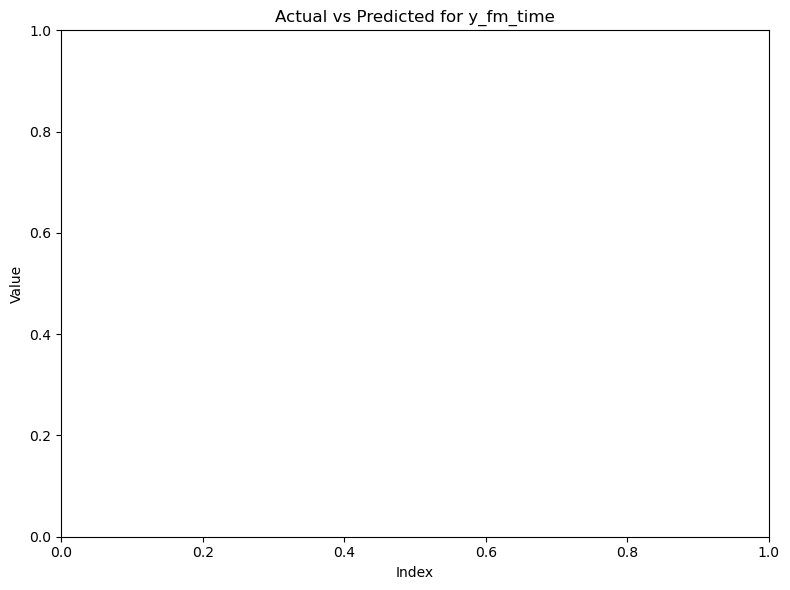

In [3]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from dotenv import load_dotenv
import requests
import json
import sys
import tempfile

# Load environment variables from .env file
load_dotenv("./.env")


arg = sys.argv[1] 

def fetch_and_clean_data(headers):
    url = 'http://35.153.93.152:4000/api/dataset'
    response = requests.get(url, headers=headers)
    if response.status_code == 200:
        df = pd.read_json(response.text)
        print("Data retrieved and loaded into DataFrame.")
        return df
    else:
        raise Exception(f"Failed to retrieve data, status code: {response.status_code}")

def preprocess_data(df):
    unNeededColumns = ['_id', '_date', '_user', 'bm_HR_max', 'bm_act_steps']
    df.drop(unNeededColumns, axis=1, inplace=True)
    dfClean = df.dropna()
    return dfClean

def split_and_scale_data(dfClean):
    X = dfClean.iloc[:, -3:]
    ys = [StandardScaler().fit_transform(dfClean.iloc[:, [i]]) for i in range(6)]
    ys = [np.ravel(y) for y in ys]  # Flatten y arrays
    return X, ys

def main(arg):
    headers = {'Authorization': 'Bearer ' + os.getenv("API_SECRET_KEY")}
    df = fetch_and_clean_data(headers)
    dfClean = preprocess_data(df)
    X, ys = split_and_scale_data(dfClean)
    
    # Splitting data for each target variable
    splits = [train_test_split(X, y, test_size=0.2, random_state=4217) for y in ys]
    
    # Models and grid definitions
    models = {
        'Linear Regression': LinearRegression(),
        'SVR': SVR(),
        'Random Forest': RandomForestRegressor(),
        'KNN': KNeighborsRegressor()
    }
    
    param_grids = {
        'Linear Regression': {'clf__fit_intercept': [True, False]},
        'SVR': {'clf__C': [0.1, 1, 10], 'clf__kernel': ['linear', 'rbf']},
        'Random Forest': {'clf__n_estimators': [50, 100, 200], 'clf__max_depth': [None, 10, 20]},
        'KNN': {'clf__n_neighbors': [3, 5, 7], 'clf__weights': ['uniform', 'distance']}
    }
    
    target_names = ['y_fm_time', 'y_fm_acc', 'y_vx_time', 'y_vx_shot_acc', 'y_vx_trg_acc', 'y_au_time']
    results = {}
    
    for target_name, split in zip(target_names, splits):
        X_train, X_test, y_train, y_test = split
        result = fit_models_and_evaluate(X_train, X_test, y_train, y_test, models, param_grids)
        plot_actual_vs_predicted(X_test, y_test, result, target_name, arg)
        results[target_name] = result
    
    # Example of how to use results, customize as needed
    print(results)

def fit_models_and_evaluate(X_train, X_test, y_train, y_test, models, param_grids):
    results = {}
    for model_name, model in models.items():
        pipe = Pipeline([('scaler', StandardScaler()), ('clf', model)])
        grid_search = GridSearchCV(pipe, param_grids[model_name], cv=5, scoring='neg_mean_squared_error')
        grid_search.fit(X_train, y_train)
        y_pred = grid_search.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        results[model_name] = {'MSE': mse}
    return results

def plot_actual_vs_predicted(X_test, y_test, results, variable, arg):
    plt.figure(figsize=(8, 6))
    # Placeholder for actual plotting, customize with your actual vs. predicted logic
    plt.title(f'Actual vs Predicted for {variable}')
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.tight_layout()
    plot_path = os.path.join(tempfile.gettempdir(), arg, f"{variable}.png")
    os.makedirs(os.path.dirname(plot_path), exist_ok=True)
    plt.savefig(plot_path)
    plt.close()

if __name__ == "__main__":
    main(arg)
